In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time

In [ ]:
from abc import ABC, abstractmethod

In [ ]:
def standardNormalGaussianDensity(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-.5*np.power(x,2))

def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMdigitalCall(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

def BSMdigitalPut(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

def BSMforwardPrice(St, K, T, t, r, q):
    return St*np.exp(-q*(T-t)) - K*np.exp(-r*(T-t))

def BSMzeroCouponBondPrice(T, t, r):
    return np.exp(-r*(T-t))

def OneDGBMPathGenerator(d,S0,T,r,q,sigma):
    """
    d : number of paths
    S0: initial stock price
    T : maturity
    r : risk free interest rate
    q : divident rate
    sigma : stock volatility
    """
    return S0*np.exp((r-q-sigma**2/2)*np.repeat(np.array([T]),d) + sigma*np.sqrt(T)*np.random.normal(size=(d)))

def BSMcallDelta(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    return np.exp(-q*(T-t))*sp.special.ndtr(_d1)

def BSMcallGamma(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    nd1 = standardNormalGaussianDensity(_d1)
    tau = T - t
    return np.exp(-q*tau)*nd1/(St*sigma*np.sqrt(tau))

def BSMcallVega(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    nd1 = standardNormalGaussianDensity(_d1)
    tau = T - t
    return St*np.exp(-q*tau)*np.sqrt(tau)*nd1

def BSMcallRho(St, K, T, t, r, q, sigma):
    _d2 = d2(St, K, T, t, r, q, sigma)
    tau = T - t
    return K*np.exp(-r*tau)*tau*sp.special.ndtr(_d2)

def BSMcallVega(St, K, T, t, r, q, sigma):
    tau = T - t
    _d1 = d1(St, K, T, t, r, q, sigma)
    _d2 = _d1 - sigma*np.sqrt(tau)
    nd1 = standardNormalGaussianDensity(_d1)
    nd1 = standardNormalGaussianDensity(_d1)
    return St*np.exp(-q*tau)*q*sp.special.ndtr(_d1) - K*np.exp(-r*tau)*r*sp.special.ndtr(_d2) - St*np.exp(-q*tau)*sigma*nd1/(2*np.sqrt(tau))

def BSMputDelta(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    return np.exp(-q*(T-t))*sp.special.ndtr(-_d1)

def BSMputGamma(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    nd1 = standardNormalGaussianDensity(_d1)
    tau = T - t
    return np.exp(-q*tau)*nd1/(St*sigma*np.sqrt(tau))

def BSMputVega(St, K, T, t, r, q, sigma):
    _d1 = d1(St, K, T, t, r, q, sigma)
    nd1 = standardNormalGaussianDensity(_d1)
    tau = T - t
    return St*np.exp(-q*tau)*np.sqrt(tau)*nd1

def BSMputRho(St, K, T, t, r, q, sigma):
    _d2 = d2(St, K, T, t, r, q, sigma)
    tau = T - t
    return -K*np.exp(-r*tau)*tau*sp.special.ndtr(-_d2)

def BSMputVega(St, K, T, t, r, q, sigma):
    tau = T - t
    _d1 = d1(St, K, T, t, r, q, sigma)
    _d2 = _d1 - sigma*np.sqrt(tau)
    nd1 = standardNormalGaussianDensity(_d1)
    nd1 = standardNormalGaussianDensity(_d1)
    return -St*np.exp(-q*tau)*q*sp.special.ndtr(-_d1) + K*np.exp(-r*tau)*r*sp.special.ndtr(-_d2) - St*np.exp(-q*tau)*sigma*nd1/(2*np.sqrt(tau))


In [ ]:
def GBMPathGenerator(n,d,S0,T,r,q,sigma):
        """
        n : dimensionality / number of increments
        d : number of paths
        S0: initial stock price
        T : maturity
        r : risk free interest rate
        q : divident rate
        sigma : stock volatility
        """
        times = np.linspace(0., T, n)
        dt = times[1] - times[0]
        timesArray = np.array([times for i in range(d)]).transpose()
        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((n, d))
        dB[1:, :] = np.sqrt(dt) * np.random.normal(size=(n-1, d))
        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = S0*np.exp((r-q-sigma**2/2)*timesArray + sigma*B)
        return S


In [ ]:
class StockMovementGenerator(ABC):
    """Abstract base class for generating stock price movements"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int, T:float):
        self.initial_price = initial_price
        self.n = n_steps # Dimensionality of Monte Carlo / Number of Increments
        self.d = n_paths # Number of Iterations / Paths
        self.T = T  # Timespan
        self.dt = self.T/(self.n-1)

    @abstractmethod
    def generate(self):
        """Generate price movements"""
        pass

class GeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 r: float, q:float, sigmaArray: np.array , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.r = r  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigmaArray = sigmaArray  # historic volatility
        self.times = np.linspace(0., self.T, self.n)
        self.timesArray = np.array([self.times for i in range(self.d)]).transpose()

    def generate(self):
        """
        Generate prices using GBM
        The generator function can take in a changing volatility

        """

         # Computing root-mean-square sigma
        rmsSigma = np.ones(shape=sigmaArray.shape)
        rmsSigma[0] = sigmaArray[0]
        rmsSigma[1:] = np.sqrt((sigmaArray[:-1]**2 + sigmaArray[1:]**2)/2)
        rmsSigma = np.repeat(rmsSigma.reshape(self.n,1), self.d, axis = 1)

        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n, self.d))
        dB[1:, :] = np.sqrt(self.dt) * np.random.normal(size=(self.n-1, self.d))
        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = self.S0*np.exp((self.r-self.q-rmsSigma**2/2)*self.timesArray + rmsSigma*B)
        return S



## Delta Hedge Strategy

Sell a call option and hold delta units of stock

$$
A = - C + N_1 \cdot S
$$

$A$ signifies the assets held.

In the delta hedge strategy $N_1 = \frac{\delta C}{\delta S}$

At every rebalancing point, the number of stocks owned is equal to $N_1$

The portfolio is made up of the assets $A$ and the cash account $B$ which is used to purchase the stock.

Then, if the rebalancing was done at every point in time the portfolio value should always be equal to 0

$$
P = A - B = 0
$$

In [ ]:
class Strategy(ABC):
    """Abstract base class for trading strategies"""

    def __init__(self):
        pass

    @abstractmethod
    def run(self):
        """Run the strategy"""
        pass

class DeltaHedgeStrategy(Strategy):
    """Delta Hedging strategy"""
    def __init__(self, S: np.array, SMG : StockMovementGenerator, K : float):
        self.S = S # Stock Price array
        self.n_steps = S.shape[0]
        self.n_paths = S.shape[1]
        self.T = SMG.T # Maturity
        self.dt = SMG.dt # Time step size
        self.sigmaArray = SMG.sigmaArray
        self.r = SMG.r # Risk Free Interest Rate
        self.q = SMG.q # Dividend Rate
        self.times = SMG.times
        self.K = K # Strike price


    def run(self):

        A = np.zeros(shape=(self.n_steps, self.n_paths)) # Assets value
        B = np.zeros(shape=(self.n_steps, self.n_paths)) # Cash Borrowed
        P = np.zeros(shape=(self.n_steps, self.n_paths)) # Portfolio value

        # In BSM world, the portfolio should be always 0.
        # Portfolio = Assets Value - Cash Borrowed

        # In Delta Hedge I sell a call option and hold a delta amount of stock at each point in time

        previous_delta = BSMcallDelta(self.S[0,:],self.K,self.T,0,self.r,self.q,self.sigmaArray[0]) # The delta stands for units of stock owned
        B[0,:] = -BSMcall(self.S[0,:],self.K,self.T,0,self.r,self.q,self.sigmaArray[0]) + previous_delta*self.S[0,:] # Cash borrowed is considered positive. Thus a negative factor means earning money
        A[0,:] = -BSMcall(self.S[0,:],self.K,self.T,0,self.r,self.q,self.sigmaArray[0]) + previous_delta*self.S[0,:]

        # Exclude the very last step where the Delta cannot be computed
        for i in range(1,self.n_steps-1):

            currentPrice = self.S[i,:]
            currentTime = self.times[i]
            sigma = self.sigmaArray[i]

            current_delta = BSMcallDelta(currentPrice,self.K,self.T,currentTime,self.r,self.q,sigma)
            delta = current_delta - previous_delta # This tells us how many units of stock we should buy now so as the portfolio stays delta neutral
            previous_delta = current_delta

            # The cash borrowed both acquires interest and increases by delta units of stock
            B[i,:] = B[i-1,:]*np.exp(self.r*self.dt) + delta*self.S[i,:]
            # The assets we have are the 1 call option sold + delta units of stock
            A[i,:] = -BSMcall(currentPrice,self.K,self.T,currentTime,self.r,self.q,sigma) + current_delta*self.S[i,:]


        P = A - B

        return P


## Portfolio made up of a call option and a delta amount of stock at each point in time

In [ ]:
T = 3
t = 0
S0 = 100
K = 103
q = .00
r = .03
sigma = .07
minPower = 5
maxPower = 11
epsilon = 1e-6

In [ ]:
portfolioMean = np.zeros(maxPower - minPower)
portfolioVar = np.zeros(maxPower - minPower)
timeStepsArray = np.power(2,np.arange(minPower,maxPower))
for idx,k in enumerate(range(minPower,maxPower)):
    n_steps = np.power(2,k)
    n_paths = np.power(2,k)
    sigmaArray = np.ones(n_steps)*sigma
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n_steps, n_paths = n_paths,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = DeltaHedgeStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioMean[idx] = np.mean(np.mean(portfolio, axis = 1))
    portfolioVar[idx] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


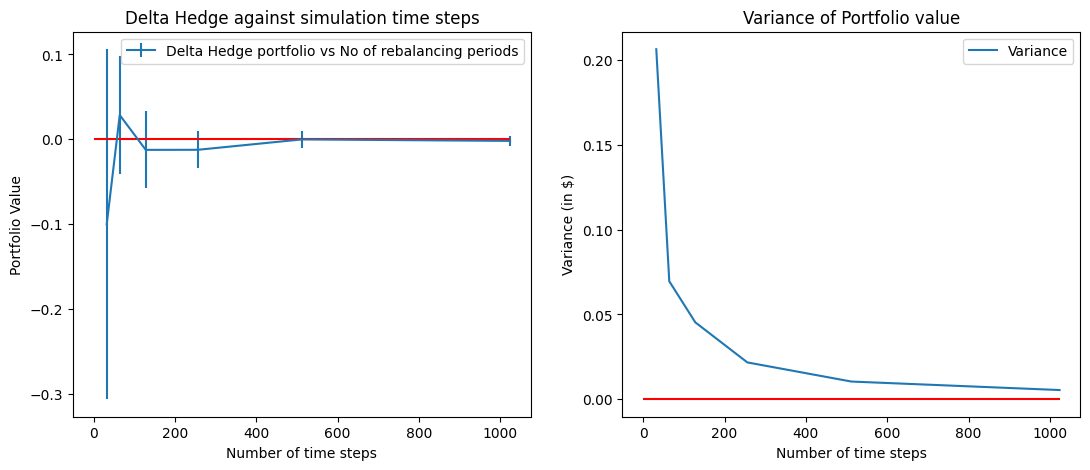

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(np.power(2,np.arange(minPower,maxPower)), portfolioMean, yerr = portfolioVar, label = "Delta Hedge portfolio vs No of rebalancing periods")
ax[0].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[0].legend()
ax[0].set_title('Delta Hedge against simulation time steps')
ax[0].set_xlabel('Number of time steps')
ax[0].set_ylabel('Portfolio Value')
ax[1].plot(np.power(2,np.arange(minPower,maxPower)), portfolioVar, label = "Variance")
ax[1].set_title('Variance of Portfolio value')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Variance (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

Clearly, the portfolio maintains an almost $0$ value at all times, improving the accuracy for a smaller time step.

The Portfolio Variance depends in an exponential decay fashion to the number of steps.

Now, let us assess how the portfolio maintains its $0$ value when the volatility $\sigma$ changes

## Delta Hedging Strategy: Portfolio value against $\sigma$

In [ ]:
NExp = 100 # Number of different sigma
sigmaList = np.linspace(0.005,0.8,NExp)
portfolioVarvsSigma = np.zeros(NExp)
n = np.power(2,9) # 512 timesteps is a reasonable grid density

for j in range(NExp):

    sigmaArray = np.ones(n)*sigmaList[j]
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n, n_paths = n,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = DeltaHedgeStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioVarvsSigma[j] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


Text(0.5, 1.0, 'Portfolio variance accross a range of volatilities')

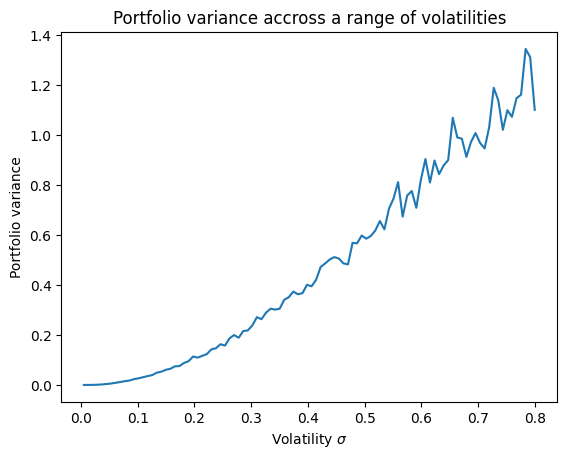

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,1)
ax.plot(sigmaList,portfolioVarvsSigma)
ax.set_xlabel(r'Volatility $\sigma$')
ax.set_ylabel('Portfolio variance')
ax.set_title('Portfolio variance accross a range of volatilities')

From the graph above, we notice the $\textbf{Portfolio variance}$ depends in an almost split power law fashion to the $\textbf{volatility}$


Let us try to see if the same dependence holds for changing drift

## Delta Hedging Strategy: Portfolio Variance against drfit $\mu$

In [ ]:
NExp = 100 # Number of different sigma
muArray = np.linspace(-0.5,0.5,NExp)
portfolioVarvsMu = np.zeros(NExp)
n = np.power(2,9) # 512 timesteps is a reasonable grid density

for j in range(NExp):

    _r = muArray[j] + (sigma**2)/2 + q
    sigmaArray = np.ones(n)*sigma
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n, n_paths = n, r = _r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = DeltaHedgeStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioVarvsMu[j] = np.mean(np.var(portfolio, axis = 1))

Using parameters: q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


Text(0.5, 1.0, 'Portfolio variance accross a range of drifts $\\mu$')

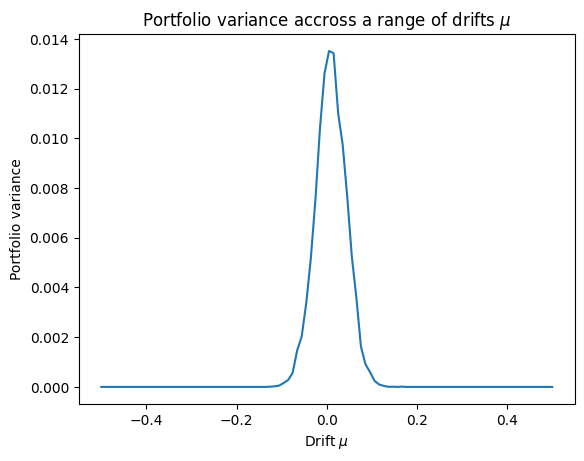

In [ ]:
print(f'Using parameters: q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,1)
ax.plot(muArray,portfolioVarvsMu)
ax.set_xlabel(r'Drift $\mu$')
ax.set_ylabel('Portfolio variance')
ax.set_title(r'Portfolio variance accross a range of drifts $\mu$')

When drift is $0$, the Portfolio variance is driven by the volatility $\sigma$ only.

When the drift dominates the movement of the stock price, the variance of the Delta Hedged portfolio becomes negligible.

### The Stop Loss strategy
Hold 1 unit of stock if $S_t > K$ at any point in time, otherwise hold no stock


In [ ]:

class StopLossStrategy(Strategy):
    """Stop Loss strategy"""
    def __init__(self, S: np.array, SMG : StockMovementGenerator, K : float):
        self.S = S # Stock Price array
        self.n_steps = S.shape[0]
        self.n_paths = S.shape[1]
        self.T = SMG.T # Maturity
        self.dt = SMG.dt # Time step size
        self.sigmaArray = SMG.sigmaArray
        self.r = SMG.r # Risk Free Interest Rate
        self.q = SMG.q # Dividend Rate
        self.times = SMG.times
        self.K = K # Strike price


    def run(self):
        # FOR MULTIPLE PATHS
        A = np.zeros(shape=(self.n_steps, self.n_paths)) # Assets value
        B = np.zeros(shape=(self.n_steps, self.n_paths)) # Cash Borrowed
        P = np.zeros(shape=(self.n_steps, self.n_paths)) # Portfolio value

        # In BSM world, the portfolio should be always 0.
        # Portfolio = Assets Value - Cash Borrowed

        # In Stop Loss I sell a call option and hold a 1 unit of stock at each point in time if S(t) > K

        previous_delta = np.ones(shape=S[0,:].shape)*int(S0>K) # The delta stands for units of stock owned
        B[0,:] = -BSMcall(S[0,:],self.K,self.T,0,self.r,self.q,self.sigmaArray[0]) + previous_delta*S[0,:] # Cash borrowed is considered positive. Thus a negative factor means earning money
        A[0,:] = -BSMcall(S[0,:],self.K,self.T,0,self.r,self.q,self.sigmaArray[0]) + previous_delta*S[0,:]

        # Exclude the very last step where the Delta cannot be computed
        for i in range(1,self.n_steps-1):

            currentPrice = S[i,:]
            currentTime = self.times[i]
            sigma = self.sigmaArray[i]

            current_delta = 1*(currentPrice > K) # Hold 1 unit of stock only if the S > K
            delta = current_delta - previous_delta # This tells us how many units of stock we should buy now so as the portfolio stays delta neutral
            previous_delta = current_delta

            # The cash borrowed both acquires interest and increases by delta units of stock
            B[i,:] = B[i-1,:]*np.exp(self.r*self.dt) + delta*S[i,:]
            # The assets we have are the 1 call option sold + delta units of stock
            A[i,:] = -BSMcall(currentPrice,self.K,self.T,currentTime,self.r,self.q,sigma) + current_delta*S[i,:]


        P = A - B

        return P



In [ ]:
portfolioMean = np.zeros(maxPower - minPower)
portfolioVar = np.zeros(maxPower - minPower)
timeStepsArray = np.power(2,np.arange(minPower,maxPower))
for idx,k in enumerate(range(minPower,maxPower)):
    n_steps = np.power(2,k)
    n_paths = np.power(2,k)
    sigmaArray = np.ones(n_steps)*sigma
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n_steps, n_paths = n_paths,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = StopLossStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioMean[idx] = np.mean(np.mean(portfolio, axis = 1))
    portfolioVar[idx] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


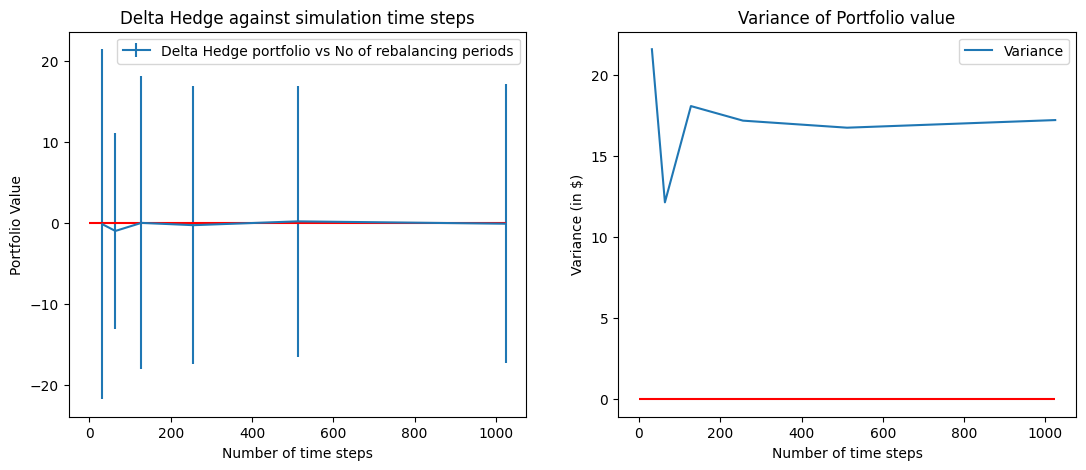

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(np.power(2,np.arange(minPower,maxPower)), portfolioMean, yerr = portfolioVar, label = "Delta Hedge portfolio vs No of rebalancing periods")
ax[0].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[0].legend()
ax[0].set_title('Delta Hedge against simulation time steps')
ax[0].set_xlabel('Number of time steps')
ax[0].set_ylabel('Portfolio Value')
ax[1].plot(np.power(2,np.arange(minPower,maxPower)), portfolioVar, label = "Variance")
ax[1].set_title('Variance of Portfolio value')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Variance (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()


## Stop Loss Strategy: Portfolio Variance against drfit $\mu$

In [ ]:
NExp = 100 # Number of different sigma
muArray = np.linspace(-0.5,0.5,NExp)
portfolioVarvsMu = np.zeros(NExp)
n = np.power(2,9) # 512 timesteps is a reasonable grid density

for j in range(NExp):

    _r = muArray[j] + (sigma**2)/2 + q
    sigmaArray = np.ones(n)*sigma
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n, n_paths = n, r = _r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = StopLossStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioVarvsMu[j] = np.mean(np.var(portfolio, axis = 1))

Using parameters: q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


Text(0.5, 1.0, 'Portfolio variance accross a range of drifts $\\mu$')

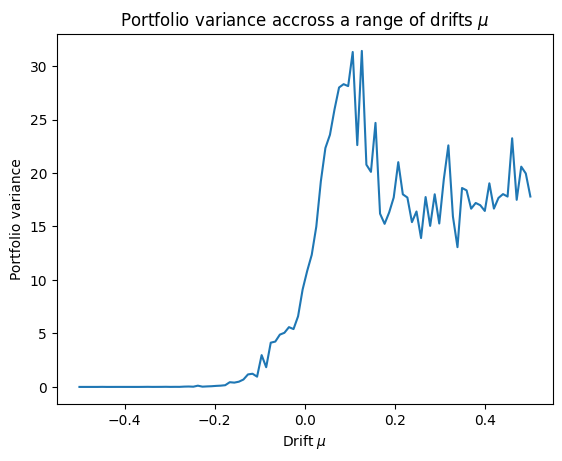

In [ ]:
print(f'Using parameters: q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,1)
ax.plot(muArray,portfolioVarvsMu)
ax.set_xlabel(r'Drift $\mu$')
ax.set_ylabel('Portfolio variance')
ax.set_title(r'Portfolio variance accross a range of drifts $\mu$')


## Stop Loss Strategy: Portfolio value against $\sigma$

In [ ]:
NExp = 100 # Number of different sigma
sigmaList = np.linspace(0.005,0.8,NExp)
portfolioVarvsSigma = np.zeros(NExp)
n = np.power(2,9) # 512 timesteps is a reasonable grid density

for j in range(NExp):

    sigmaArray = np.ones(n)*sigmaList[j]
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n, n_paths = n,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = StopLossStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioVarvsSigma[j] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


Text(0.5, 1.0, 'Portfolio variance accross a range of volatilities')

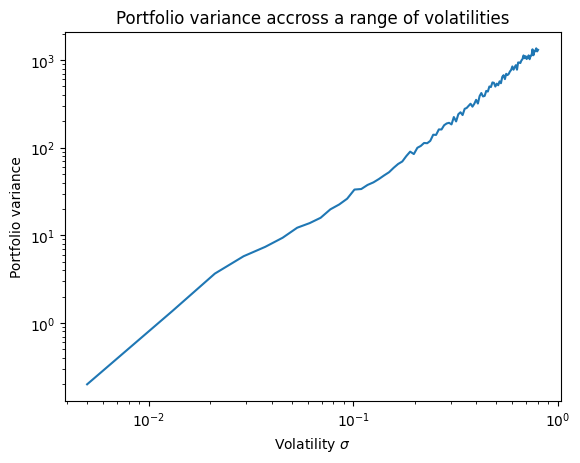

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,1)
ax.loglog(sigmaList,portfolioVarvsSigma)
ax.set_xlabel(r'Volatility $\sigma$')
ax.set_ylabel('Portfolio variance')
ax.set_title('Portfolio variance accross a range of volatilities')

### GAMMA Hedging
Keep a portfolio delta neutral and use another option of a different strike to have the portfolio Gamma neutral as well

## Gamma Hedge Strategy

Sell a call option and hold $N_1$ units of stock and $N_2$ units of a different asset (e.g. an out of the money call)

$$
A = - C_1 + N_1 \cdot S + N_2 \cdot C_2
$$

$A$ signifies the assets held.

In the gamma hedge strategy

$N_1 = \frac{\delta C_1}{\delta S} - N_2 \cdot \frac{\delta C_2}{\delta S}$

$N_2 = \frac{\Gamma_1}{\Gamma_2}$

At every rebalancing point, the number of stocks owned is equal to $N_1$ and number of options $C_2$ owned is $N_2$.

By taking $N_1$ and $N_2$ as constants, one can clearly see that

$\frac{\delta A}{\delta S} = 0$

and

$\frac{\delta^2 A}{\delta S^2} = 0$,

as intended.

The portfolio is made up of the assets $A$ and the cash account $B$ which is used to purchase the stock.

Then, if the rebalancing was done at every point in time the portfolio value should always be equal to 0

$$
P = A - B = 0
$$

In [ ]:
class GammaHedgeStrategy(Strategy):
    """Gamma Hedge strategy"""
    def __init__(self, S: np.array, SMG : StockMovementGenerator, K : float, K2: float):
        self.S = S # Stock Price array
        self.n_steps = S.shape[0]
        self.n_paths = S.shape[1]
        self.T = SMG.T # Maturity
        self.dt = SMG.dt # Time step size
        self.sigmaArray = SMG.sigmaArray
        self.r = SMG.r # Risk Free Interest Rate
        self.q = SMG.q # Dividend Rate
        self.times = SMG.times
        self.K = K # Strike price
        self.K2 = K2 # Strike Price of second option


    def run(self):
        A = np.zeros(shape=(self.n_steps, self.n_paths)) # Assets value
        B = np.zeros(shape=(self.n_steps, self.n_paths)) # Cash Borrowed
        P = np.zeros(shape=(self.n_steps, self.n_paths)) # Portfolio value

        _gamma1 = BSMcallGamma(self.S[0,:], self.K, self.T, self.times[0], self.r, self.q, self.sigmaArray[0])
        _gamma2 = BSMcallGamma(self.S[0,:], self.K2, self.T, self.times[0], self.r, self.q, self.sigmaArray[0])
        delta1 = BSMcallDelta(self.S[0,:], self.K, self.T, self.times[0], self.r, self.q, self.sigmaArray[0])
        delta2 = BSMcallDelta(self.S[0,:], self.K2, self.T, self.times[0], self.r, self.q, self.sigmaArray[0])
        _call1 = BSMcall(self.S[0,:], self.K, self.T, self.times[0], self.r, self.q, self.sigmaArray[0])
        _call2 = BSMcall(self.S[0,:], self.K2, self.T, self.times[0], self.r, self.q, self.sigmaArray[0])

        N2_prev = np.ones(shape=self.S[0,:].shape)*(_gamma1/_gamma2)
        N1_prev = delta1 - N2_prev*delta2
        B[0,:] = -_call1 + N1_prev*self.S[0,:] + N2_prev*_call2
        A[0,:] = B[0,:] # Self financing equality enforced at first step

        for i in range(1,self.n_steps-1):

            currentPrice = self.S[i,:]
            currentTime = self.times[i]
            sigma = self.sigmaArray[i]
            currentCallTwoPrice = BSMcall(currentPrice,self.K2, self.T, currentTime, self.r, self.q,sigma)
            current_delta = BSMcallDelta(currentPrice,self.K, self.T, currentTime, self.r, self.q,sigma)

            _gamma2 = np.maximum(BSMcallGamma(currentPrice,self.K2, self.T, currentTime, self.r, self.q,sigma), epsilon*np.ones(shape=currentPrice.shape))
            N2_current = np.ones(shape=self.S[0,:].shape)*(BSMcallGamma(currentPrice,self.K, self.T, currentTime, self.r, self.q,sigma)/_gamma2)
            N1_current = BSMcallDelta(currentPrice,self.K, self.T, currentTime, self.r, self.q,sigma) - N2_current*BSMcallDelta(currentPrice,self.K2, self.T, currentTime, self.r, self.q,sigma)

            N1_delta = N1_current - N1_prev
            N2_delta = N2_current - N2_prev
            N1_prev = N1_current
            N2_prev = N2_current

            B[i,:] = B[i-1,:]*np.exp(self.r*self.dt) + N1_delta*self.S[i,:] + N2_delta*currentCallTwoPrice

            A[i,:] = -BSMcall(currentPrice,self.K, self.T, currentTime, self.r, self.q,sigma) + N1_current*self.S[i,:] + N2_current*currentCallTwoPrice


        P = A - B

        return P

In [ ]:
T = 3
t = 0
S0 = 100
K = 103
q = .00
r = .03
sigma = .07
K2 = 90 # This is an out of the money option

In [ ]:
portfolioMean = np.zeros(maxPower - minPower)
portfolioVar = np.zeros(maxPower - minPower)
timeStepsArray = np.power(2,np.arange(minPower,maxPower))
for idx,k in enumerate(range(minPower,maxPower)):
    n_steps = np.power(2,k)
    n_paths = np.power(2,k)
    sigmaArray = np.ones(n_steps)*sigma
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n_steps, n_paths = n_paths,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    GS = GammaHedgeStrategy(S, GBM,K,K2)
    portfolio = GS.run()

    portfolioMean[idx] = np.mean(np.mean(portfolio, axis = 1))
    portfolioVar[idx] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


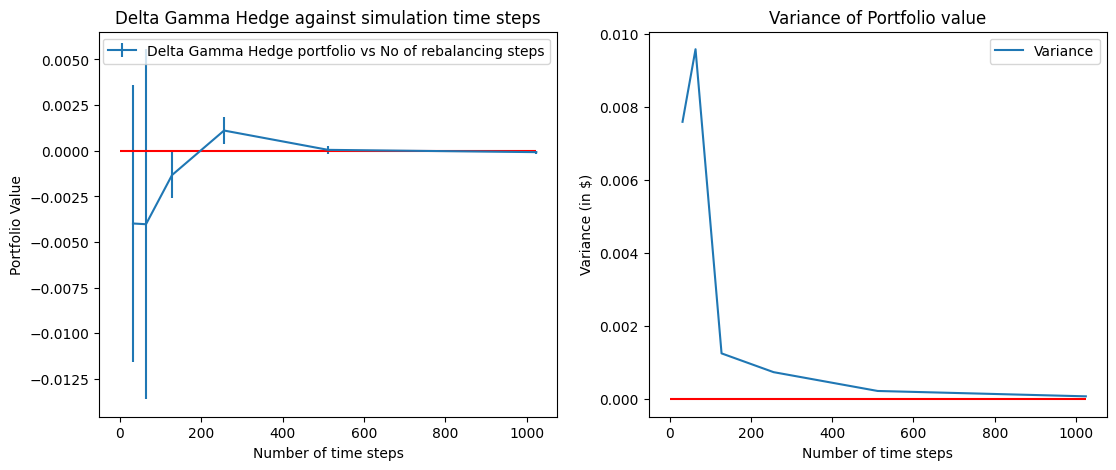

In [ ]:
pathsArray = np.power(2,np.arange(minPower,maxPower))
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(pathsArray, portfolioMean, yerr = portfolioVar, label = "Delta Gamma Hedge portfolio vs No of rebalancing steps")
ax[0].legend()
ax[0].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[0].set_title('Delta Gamma Hedge against simulation time steps')
ax[0].set_xlabel('Number of time steps')
ax[0].set_ylabel('Portfolio Value')
ax[1].plot(pathsArray, portfolioVar, label = "Variance")
ax[1].set_title('Variance of Portfolio value')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Variance (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

# TIME DEPENDENT VOLATILITY & DELTA HEDGE

 ### (i) Delta hedge using instantaneous sigma value

In [ ]:
portfolioMean = np.zeros(maxPower - minPower)
portfolioVar = np.zeros(maxPower - minPower)
timeStepsArray = np.power(2,np.arange(minPower,maxPower))
for idx,k in enumerate(range(minPower,maxPower)):
    n_steps = np.power(2,k)
    n_paths = np.power(2,k)
    times = np.linspace(0, T, n_steps)
    sigmaArray = np.cos((2*3.14/(6*T))*times)*0.08 # The vol will slowly decrease from 0.8 to 0.4
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n_steps, n_paths = n_paths,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = DeltaHedgeStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioMean[idx] = np.mean(np.mean(portfolio, axis = 1))
    portfolioVar[idx] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


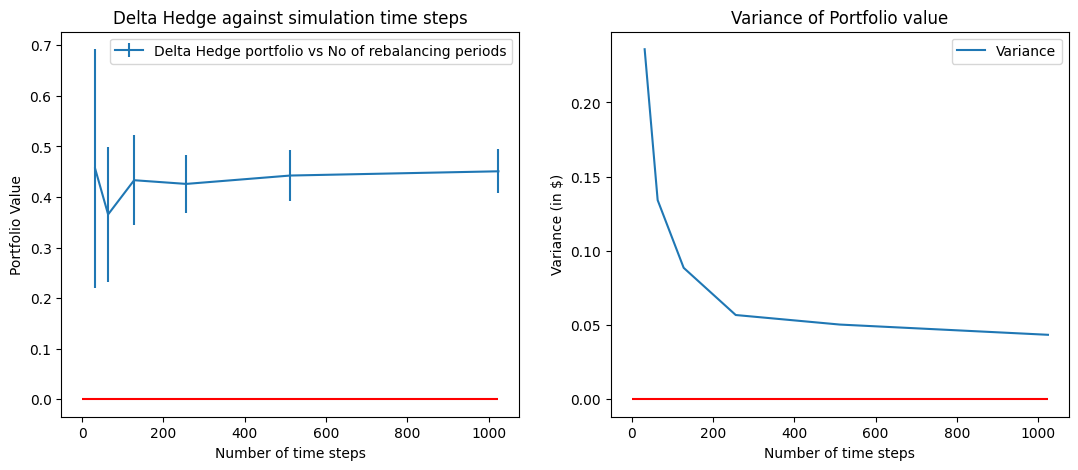

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(np.power(2,np.arange(minPower,maxPower)), portfolioMean, yerr = portfolioVar, label = "Delta Hedge portfolio vs No of rebalancing periods")
ax[0].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[0].legend()
ax[0].set_title('Delta Hedge against simulation time steps')
ax[0].set_xlabel('Number of time steps')
ax[0].set_ylabel('Portfolio Value')
ax[1].plot(np.power(2,np.arange(minPower,maxPower)), portfolioVar, label = "Variance")
ax[1].set_title('Variance of Portfolio value')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Variance (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

### (2) Delta Hedge using RMS average value

In [ ]:

class DeltaHedgeRMSSigmaStrategy(Strategy):
    """Delta Hedging strategy"""
    def __init__(self, S: np.array, SMG : StockMovementGenerator, K : float):
        self.S = S # Stock Price array
        self.n_steps = S.shape[0]
        self.n_paths = S.shape[1]
        self.T = SMG.T # Maturity
        self.dt = SMG.dt # Time step size
        self.sigmaArray = SMG.sigmaArray
        self.r = SMG.r # Risk Free Interest Rate
        self.q = SMG.q # Dividend Rate
        self.times = SMG.times
        self.K = K # Strike price


    def run(self):

        A = np.zeros(shape=(self.n_steps, self.n_paths)) # Assets value
        B = np.zeros(shape=(self.n_steps, self.n_paths)) # Cash Borrowed
        P = np.zeros(shape=(self.n_steps, self.n_paths)) # Portfolio value
        # Computing root-mean-square sigma
        avgRMSsigma = np.sqrt(np.mean(self.sigmaArray**2))

        # In BSM world, the portfolio should be always 0.
        # Portfolio = Assets Value - Cash Borrowed

        # In Delta Hedge I sell a call option and hold a delta amount of stock at each point in time

        previous_delta = BSMcallDelta(self.S[0,:],self.K,self.T,0,self.r,self.q,avgRMSsigma) # The delta stands for units of stock owned
        B[0,:] = -BSMcall(self.S[0,:],self.K,self.T,0,self.r,self.q,avgRMSsigma) + previous_delta*self.S[0,:] # Cash borrowed is considered positive. Thus a negative factor means earning money
        A[0,:] = -BSMcall(self.S[0,:],self.K,self.T,0,self.r,self.q,avgRMSsigma) + previous_delta*self.S[0,:]

        # Exclude the very last step where the Delta cannot be computed
        for i in range(1,self.n_steps-1):

            currentPrice = self.S[i,:]
            currentTime = self.times[i]

            current_delta = BSMcallDelta(currentPrice,self.K,self.T,currentTime,self.r,self.q,avgRMSsigma)
            delta = current_delta - previous_delta # This tells us how many units of stock we should buy now so as the portfolio stays delta neutral
            previous_delta = current_delta

            # The cash borrowed both acquires interest and increases by delta units of stock
            B[i,:] = B[i-1,:]*np.exp(self.r*self.dt) + delta*self.S[i,:]
            # The assets we have are the 1 call option sold + delta units of stock
            A[i,:] = -BSMcall(currentPrice,self.K,self.T,currentTime,self.r,self.q,avgRMSsigma) + current_delta*self.S[i,:]


        P = A - B

        return P


In [ ]:
portfolioMean = np.zeros(maxPower - minPower)
portfolioVar = np.zeros(maxPower - minPower)
timeStepsArray = np.power(2,np.arange(minPower,maxPower))
for idx,k in enumerate(range(minPower,maxPower)):
    n_steps = np.power(2,k)
    n_paths = np.power(2,k)
    times = np.linspace(0, T, n_steps)
    sigmaArray = np.cos((2*3.14/(6*T))*times)*0.08 # The vol will slowly decrease from 0.8 to 0.4
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n_steps, n_paths = n_paths,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = DeltaHedgeRMSSigmaStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioMean[idx] = np.mean(np.mean(portfolio, axis = 1))
    portfolioVar[idx] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


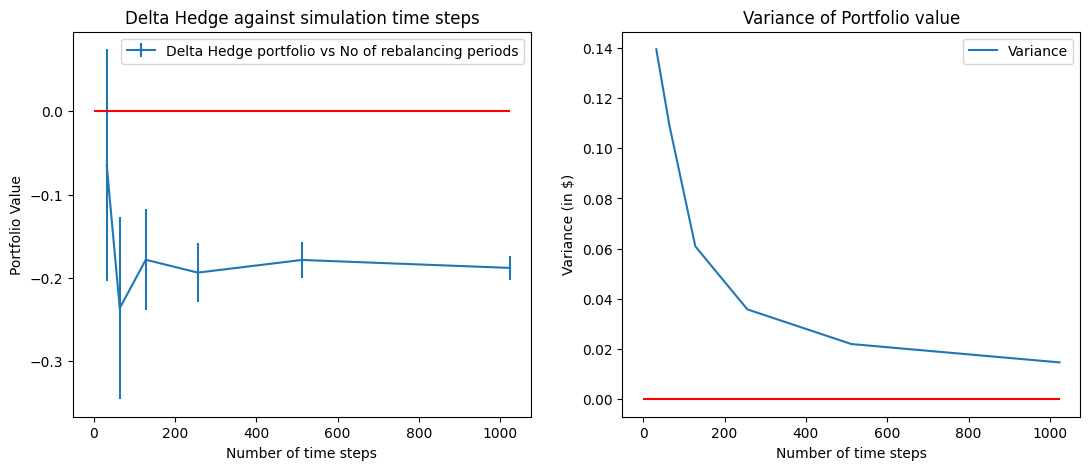

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(np.power(2,np.arange(minPower,maxPower)), portfolioMean, yerr = portfolioVar, label = "Delta Hedge portfolio vs No of rebalancing periods")
ax[0].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[0].legend()
ax[0].set_title('Delta Hedge against simulation time steps')
ax[0].set_xlabel('Number of time steps')
ax[0].set_ylabel('Portfolio Value')
ax[1].plot(np.power(2,np.arange(minPower,maxPower)), portfolioVar, label = "Variance")
ax[1].set_title('Variance of Portfolio value')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Variance (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

### (iii) Delta Hedge using forward sigma

In [ ]:

class DeltaHedgeForwardSigmaStrategy(Strategy):
    """Delta Hedging strategy"""
    def __init__(self, S: np.array, SMG : StockMovementGenerator, K : float):
        self.S = S # Stock Price array
        self.n_steps = S.shape[0]
        self.n_paths = S.shape[1]
        self.T = SMG.T # Maturity
        self.dt = SMG.dt # Time step size
        self.sigmaArray = SMG.sigmaArray
        self.r = SMG.r # Risk Free Interest Rate
        self.q = SMG.q # Dividend Rate
        self.times = SMG.times
        self.K = K # Strike price


    def run(self):

        A = np.zeros(shape=(self.n_steps, self.n_paths)) # Assets value
        B = np.zeros(shape=(self.n_steps, self.n_paths)) # Cash Borrowed
        P = np.zeros(shape=(self.n_steps, self.n_paths)) # Portfolio value

        # In BSM world, the portfolio should be always 0.
        # Portfolio = Assets Value - Cash Borrowed

        # In Delta Hedge I sell a call option and hold a delta amount of stock at each point in time
        avgRMSsigma = np.sqrt(np.mean(sigmaArray**2))

        previous_delta = BSMcallDelta(self.S[0,:],self.K,self.T,0,self.r,self.q,avgRMSsigma) # The delta stands for units of stock owned
        B[0,:] = -BSMcall(self.S[0,:],self.K,self.T,0,self.r,self.q,avgRMSsigma) + previous_delta*self.S[0,:] # Cash borrowed is considered positive. Thus a negative factor means earning money
        A[0,:] = -BSMcall(self.S[0,:],self.K,self.T,0,self.r,self.q,avgRMSsigma) + previous_delta*self.S[0,:]

        # Exclude the very last step where the Delta cannot be computed
        for i in range(1,self.n_steps-1):

            currentPrice = self.S[i,:]
            currentTime = self.times[i]
            sigma = np.sqrt(np.mean(sigmaArray[i:]**2))

            current_delta = BSMcallDelta(currentPrice,self.K,self.T,currentTime,self.r,self.q,sigma)
            delta = current_delta - previous_delta # This tells us how many units of stock we should buy now so as the portfolio stays delta neutral
            previous_delta = current_delta

            # The cash borrowed both acquires interest and increases by delta units of stock
            B[i,:] = B[i-1,:]*np.exp(self.r*self.dt) + delta*self.S[i,:]
            # The assets we have are the 1 call option sold + delta units of stock
            A[i,:] = -BSMcall(currentPrice,self.K,self.T,currentTime,self.r,self.q,sigma) + current_delta*self.S[i,:]


        P = A - B

        return P


In [ ]:
portfolioMean = np.zeros(maxPower - minPower)
portfolioVar = np.zeros(maxPower - minPower)
timeStepsArray = np.power(2,np.arange(minPower,maxPower))
for idx,k in enumerate(range(minPower,maxPower)):
    n_steps = np.power(2,k)
    n_paths = np.power(2,k)
    times = np.linspace(0, T, n_steps)
    sigmaArray = np.cos((2*3.14/(6*T))*times)*0.08 # The vol will slowly decrease from 0.8 to 0.4
    GBM = GeometricBrownianMotion(initial_price = S0, n_steps = n_steps, n_paths = n_paths,r = r, q = q, T = T,sigmaArray = sigmaArray)
    S = GBM.generate()
    DS = DeltaHedgeForwardSigmaStrategy(S, GBM,K)
    portfolio = DS.run()

    portfolioMean[idx] = np.mean(np.mean(portfolio, axis = 1))
    portfolioVar[idx] = np.mean(np.var(portfolio, axis = 1))

Using parameters: r = 0.03, q = 0.00, sigma = 0.07, t = 0.00 years, T = 3.00 years, S0 = 100.00, K = 103.00


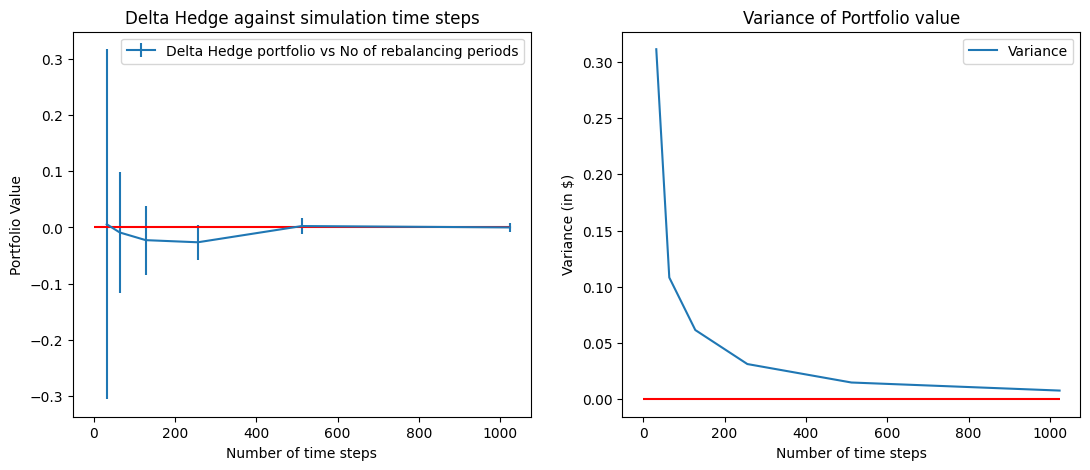

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(np.power(2,np.arange(minPower,maxPower)), portfolioMean, yerr = portfolioVar, label = "Delta Hedge portfolio vs No of rebalancing periods")
ax[0].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[0].legend()
ax[0].set_title('Delta Hedge against simulation time steps')
ax[0].set_xlabel('Number of time steps')
ax[0].set_ylabel('Portfolio Value')
ax[1].plot(np.power(2,np.arange(minPower,maxPower)), portfolioVar, label = "Variance")
ax[1].set_title('Variance of Portfolio value')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Variance (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

IT WORKS!